# How many BC are needed to achieve good statistics for $\mu$ = 0.01
## Statistical error < 1%

In [2]:
!pip install ipynb
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import matplotlib.pyplot as plt
import time 
from array import array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator
from ipynb.fs.defs.Simulation_Ruben import noise_generator, signal_generator


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Welcome to JupyROOT 6.22/08


In [3]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage, large_window_factor):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count, large_window_factor)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(1,bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true[BC] = total_signal_est - total_actual_signal
     
    deviation_from_true = deviation_from_true/bunch_crossings
    
    return result_true_signal_count, result_estimated_signal_count, deviation_from_true

In [4]:
def find_best_threshold (total_deviation):
    """Input parameter is a list of the deviations for each threshold, returns the best threshold with lowest deviation"""
    
    total_deviation = [round(num, 6) for num in total_deviation]

    best_array_indexes = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
    best_thresholds_array = np.zeros(len(best_array_indexes))
    if len(best_array_indexes)==1:
         #print("best threshold: %f" %(threshold_array[best_array_indexes[0]]))
        
         return threshold_array[best_array_indexes[0]]
    
    else: 
        for i in range (len(best_array_indexes)):
            best_thresholds_array[i] = threshold_array[best_array_indexes[i]]
        best = sum(best_thresholds_array)/len(best_thresholds_array)
        #print ("Best threshold: %f"%best)
        return best

In [18]:
nr_of_channels = int(3.6 * 1e6) #number of channels on the HGTD

mu = 0.01 # Parameter for the number of interaction in a bunch crossing
bunch_crossings = 1000

large_window_factor = 8 #How many times the large window is bigger than the smaller one

"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
print("Expected count: %f" %expected_count)

ratio_of_channels_to_sample = 1 # Choose according to how many channels, or which part of the detector, are hit

# Thresholds for the simulation
min_threshold = 28#mV
max_threshold = 33#mV
threshold_steps = 31 #Number of steps

mpv_peak = 100#mV
# To simulate only a single mpv of peak voltage, put same value for min and max, and step=1 
min_mpv_peak = 100 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
mpv_peak_steps = 1 # Number of steps
guess_mpv_voltage_bias = 1 # Set the bias of guessed mpv voltage, e.g. 0.97 for a 3% bias

Expected count: 0.750000


In [19]:
start_time = time.time()

# Input parameters 
threshold_array = 0
threshold_array = np.linspace(min_threshold,max_threshold,threshold_steps)

# Output data
mean_values = []
mean_values_with_std = []
std_values = []
total_deviation= np.zeros(len(threshold_array))
iteration = 0

for threshold in threshold_array:
    true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, mpv_peak, mpv_peak, large_window_factor)
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""

    true_signal_sum = true_signal.sum()
    if true_signal_sum == 0:
        deviation = 0
    deviation = abs(estimated_signal.sum() / true_signal_sum -1)
    total_deviation[iteration] = deviation
    #print("\nDeviation for threshold %f: %f" %(threshold, total_deviation[iteration]))

    mean_values.append(abs(np.mean(dev_per_BC)))
    mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
    print ("%.2f threshold - Mean dev: %f" %(threshold, mean_values[iteration]))
    std_values.append(np.std(dev_per_BC))
    print ("                - Std: %f" %( std_values[iteration]))
    print ("                - Tot dev: %f" %deviation)
    iteration = iteration+1

best_threshold = find_best_threshold(mean_values)
best_threshold_tot_dev = find_best_threshold(total_deviation)
print("Best threshold: %f"%best_threshold)
print("Best threshold by total deviation: %f"%best_threshold_tot_dev)
print ("\n------------------------------------------------------------") 
    
hours, rem = divmod(time.time()-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Computation done!\nCPU time: %d hours, %d minutes and %d seconds" %(hours, minutes,seconds))


28.00 threshold - Mean dev: 0.000002
                - Std: 0.000112
                - Tot dev: 0.002111
28.17 threshold - Mean dev: 0.000007
                - Std: 0.000125
                - Tot dev: 0.009891
28.33 threshold - Mean dev: 0.000001
                - Std: 0.000085
                - Tot dev: 0.001279
28.50 threshold - Mean dev: 0.000002
                - Std: 0.000071
                - Tot dev: 0.002216
28.67 threshold - Mean dev: 0.000003
                - Std: 0.000054
                - Tot dev: 0.004099
28.83 threshold - Mean dev: 0.000000
                - Std: 0.000064
                - Tot dev: 0.000487
29.00 threshold - Mean dev: 0.000002
                - Std: 0.000048
                - Tot dev: 0.002748
29.17 threshold - Mean dev: 0.000002
                - Std: 0.000039
                - Tot dev: 0.002925
29.33 threshold - Mean dev: 0.000002
                - Std: 0.000038
                - Tot dev: 0.002343
29.50 threshold - Mean dev: 0.000001
                - 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


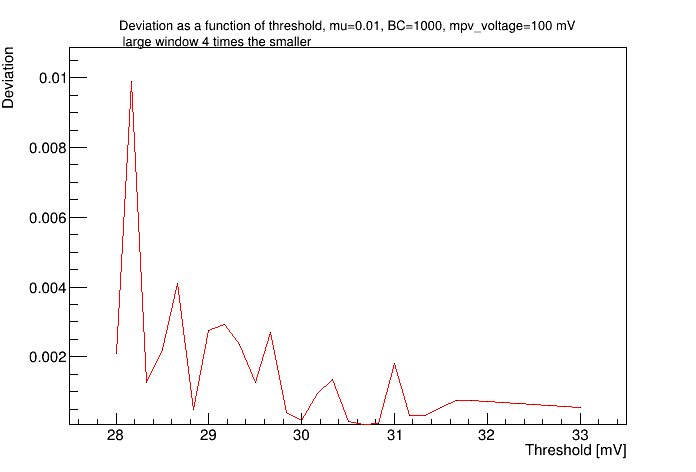

In [20]:
# Determine threshold that yields the lowest deviation 
#best = find_best_threshold(total_deviation)

c = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%.2f, BC=%d, mpv_voltage=%d mV}{\n large window 4 times the smaller}"  %(mu, bunch_crossings, mpv_peak))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw() 
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: std over Threshold
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean_std


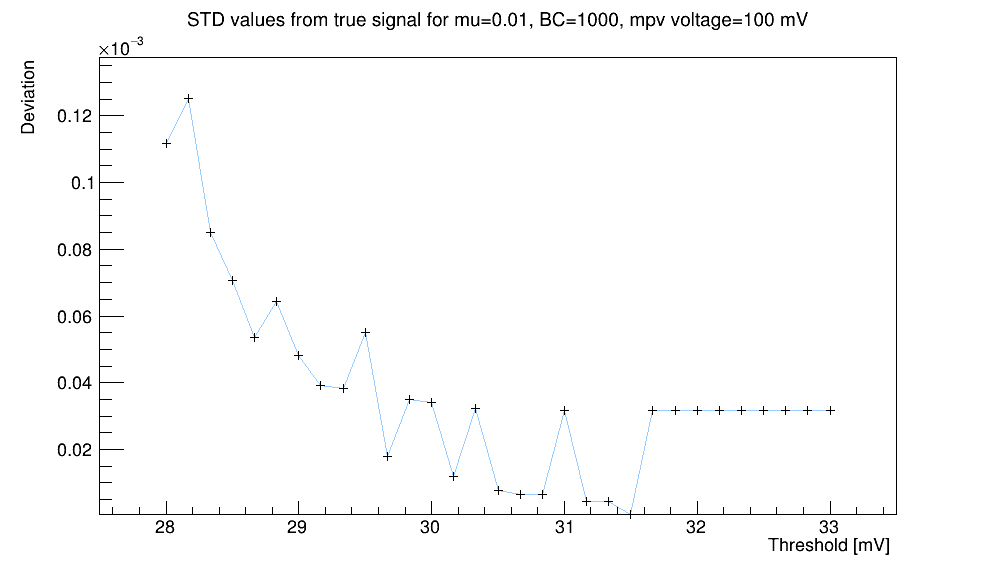

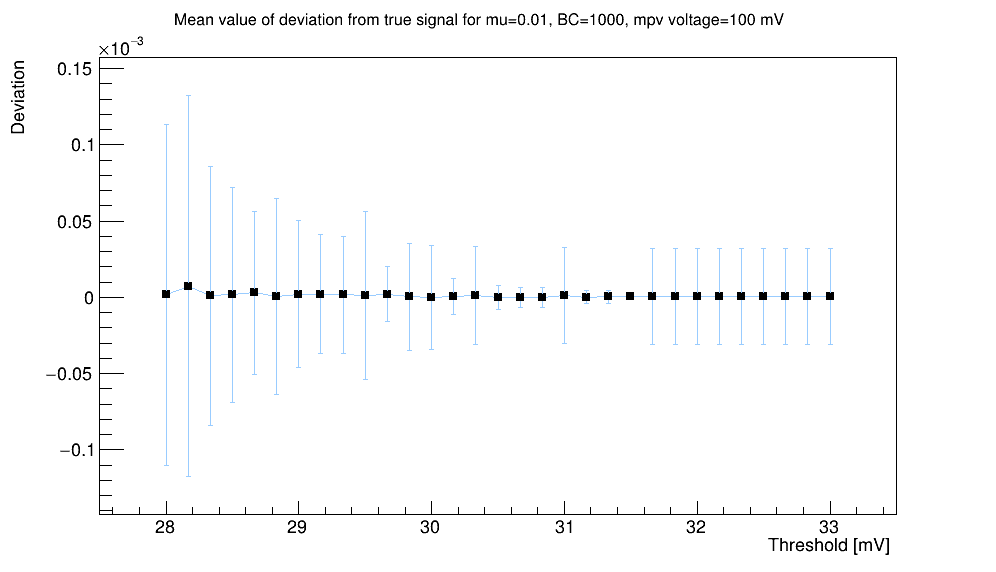

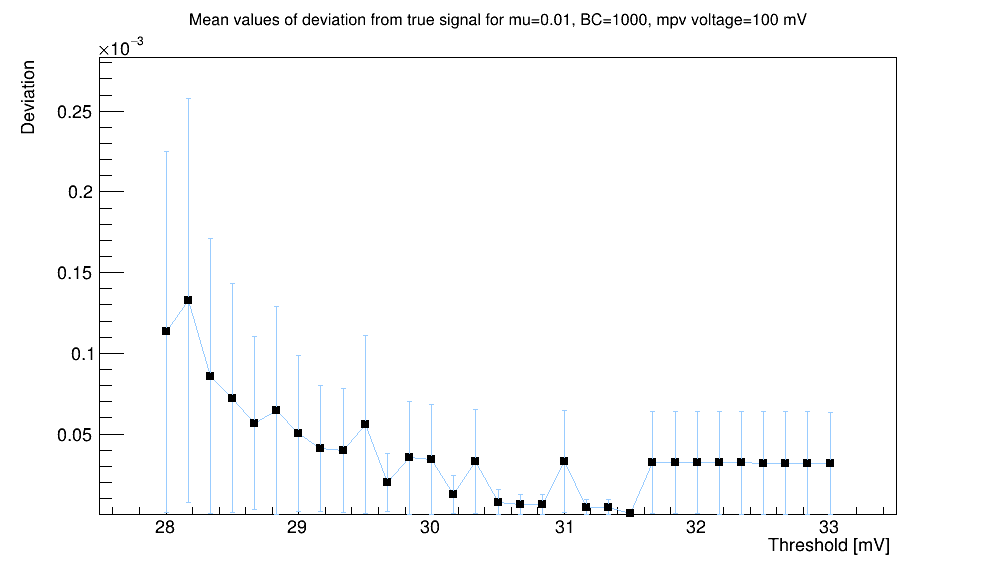

In [21]:
threshold_error = []
mean_rel = []
std_rel= []
mean_std_rel = []

#Calculate relative error for each array
for i in range (len(threshold_array)):
    threshold_error.append(0)
    #multiply by 100 to get relative error 
    std_rel.append(std_values[i])
    mean_rel.append(mean_values[i])
    mean_std_rel.append(mean_values_with_std[i])

"""Standard deviation vs threshold plot"""

#create x,y values and corresponding errors
n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
y  = array( 'f', std_rel)
ey = array( 'f', threshold_error) 

std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c1 = ROOT.TCanvas("std over Threshold", "Difference in counts", 1000, 600)
std_graph.SetTitle("STD values from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Deviation; Z axis title" %(mu, bunch_crossings, mpv_peak))
std_graph.SetMarkerStyle(2)
std_graph.SetLineColor(ROOT.kAzure-9)
std_graph.SetFillColor(ROOT.kAzure-14)
std_graph.Draw()
#c1.SetLogy()
c1.Draw()


"""Mean value vs threshold plot"""
y  = array( 'f', mean_rel)
ey = array( 'f', std_rel) 
deviation_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c2 = ROOT.TCanvas("mean canvas", "", 1000, 600)
deviation_graph.SetTitle("Mean value of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Deviation; Z axis title" %(mu, bunch_crossings, mpv_peak))
deviation_graph.SetMarkerStyle(21)
deviation_graph.SetLineColor(ROOT.kAzure-9)
deviation_graph.SetFillColor(ROOT.kAzure-14)
deviation_graph.Draw()
#c2.SetLogy()
c2.Draw()


"""Mean+std vs threshold plot"""
y  = array( 'f', mean_std_rel)
ey = array( 'f', std_rel) 
mean_std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )
c3 = ROOT.TCanvas("mean_std", "Difference in counts", 1000, 600)
mean_std_graph.SetTitle("Mean values of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Deviation; Z axis title" %(mu, bunch_crossings, mpv_peak))
mean_std_graph.SetMarkerStyle(21)
mean_std_graph.SetLineColor(ROOT.kAzure-9)
mean_std_graph.SetFillColor(ROOT.kAzure-14)
mean_std_graph.Draw()
#c3.SetLogy()
c3.Draw()